# Best Trotter Steps

We would like to know, given a certain final time $t$, which is the optimal number of Trotter steps $N_t$ that minimizes the error. The latter has two main components:
* Trotter error $\epsilon_{tr}$
* Circuit error $\epsilon_{circ}$

## Trotter error

We found a formula in [The Theory of Trotter Error with Commutator Scaling](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020) for $k$-local Hamiltonians:

$$ \epsilon_{tr} = n^k ||| H |||_1 || H ||_1^{o(1)} t^{1+o(1)}$$

where, in our case, $k=3$ for the three-body interaction term (matter-gauge-matter), $n$ is the number of spins (qubits), $t$ is the final time, and $|||\cdot|||_1$ is the _induced 1-norm_ of the operator $\cdot$.

### Semplifications

The induced 1-norm for an operator $A$ is upper bounded by the 1-norm
$$||| A |||_1 \leq || A ||_1 $$
and the $|| A ||_1$ corresponds to the sum of the largest singular values of the $\Gamma$ summands of $A$, that is, $\sum_{\gamma=1}^{\Gamma} ||A_{\gamma}||$.

So that we have to find $\left(|| H ||_1\right)^2$.

### Hamiltonian:

$$H = - J \sum_n \tau_n^{z} - h \sum_n \sigma_{(n, n+1)}^{z} - \lambda \sum_n \tau^{x}_{n+1} \sigma_{(n, n+1)}^{x} \tau^{x}_n$$

We can use **sub-additive**, **scalar multiplication**, and **triangular inequality** to find

$$||H||_1 \leq \left|J\right| \left|\left|\sum_n \tau_n^{z}\right|\right| + \left|h\right| \left|\left| \sum_n \sigma_{(n, n+1)}^{z}\right|\right| + \left|\lambda\right|  \left|\left| \sum_n \tau^{x}_{n+1} \sigma_{(n, n+1)}^{x} \tau^{x}_n\right|\right| $$


In [1]:
from z2chain.exact import sparse_hamiltonian
from scipy.sparse.linalg import svds
from numpy.linalg import svd

L = 3 # dual space sites
n = 2*L-1 # qubits, (n//2)+1 of matter and n//2 of gauge
J = 1
h = 0.05
lamb = 0.7
H = sparse_hamiltonian(J=J,h=h,lamb=lamb,chain_length=L)
print(f"qubits: {n}, matter sites: {n//2+1}, gauge sites: {n//2}")

u,s_sp,v = svds(H)
print(max(s_sp), len(s_sp))

# u,s,v = svd(H.toarray())
# print(max(s), len(s))

qubits: 5, matter sites: 3, gauge sites: 2
3.338025464577649 6


In [2]:
import numpy as np
def hamiltonian_norm_bound(hamiltonian_params):
    if hamiltonian_params.get('ham_name') == "z2higgs":
        chain_length = hamiltonian_params.get('chain_length')
        J = hamiltonian_params.get('J')
        h = hamiltonian_params.get('h')
        lamb = hamiltonian_params.get('lamb')
        n = 2*chain_length - 1
        matter_norm = J*((n//2) + 1)
        gauge_norm = h*(n//2)
        int_norm = lamb*(n//2)
        return matter_norm + gauge_norm + int_norm

def hamiltonian_norm(hamiltonian_params):
    if hamiltonian_params.get('ham_name') == "z2higgs":
        chain_length = hamiltonian_params.get('chain_length')
        n = 2*chain_length - 1
        J = hamiltonian_params.get('J')
        h = hamiltonian_params.get('h')
        lamb = hamiltonian_params.get('lamb')
        H = sparse_hamiltonian(J=J,h=h,lamb=lamb,chain_length=chain_length)
        print(f"qubits: {n}, matter sites: {n//2+1}, gauge sites: {n//2}")

        u,s_sp,v = svds(H)
        print(max(s_sp))
        norm = max(s_sp)
        return norm
    
def complexity_trotter_error_bound(k: int, final_time: float, params: dict):
    # H_norm = hamiltonian_norm_bound(hamiltonian_params=params)
    H_norm = hamiltonian_norm(hamiltonian_params=params)
    chain_length = params.get('chain_length')
    n = 2*chain_length - 1
    return n**k * H_norm * final_time

def trotter_error_bound(p_order: int, final_time: float, trotter_steps: int, params: dict):
    H_norm = hamiltonian_norm(hamiltonian_params=params)
    return (H_norm * final_time)**(p_order+1) / (trotter_steps**p_order)

def trotter_step_bound(p_order: int, final_time: float, error: int, params: dict):
    H_norm = hamiltonian_norm(hamiltonian_params=params)
    return H_norm**(1+1/p_order) * final_time**(1+1/p_order) / error**(1/p_order)

def other_formula(k, hamiltonian_params, final_time, error):
    tau = k**2 * hamiltonian_norm(hamiltonian_params=hamiltonian_params) * final_time
    return tau*(np.log(tau/error))/(np.log(np.log(tau/error)))

In [3]:
L = 5
J = 1
h = 0.05
lamb = 0.7
final_time = 8
layers = 100
model = "z2higgs"
err = 1e-1
hamiltonian_params = dict(chain_length=L, J=J, h=h, lamb=lamb, ham_name=model)
eps_tr = complexity_trotter_error_bound(k=3, final_time=8, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter error complexity: {eps_tr}")
eps_tr = trotter_error_bound(p_order=2, final_time=8, trotter_steps=layers, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter error bound: {eps_tr}")
eps_tr = trotter_step_bound(p_order=2, final_time=8, error=err, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter step bound for err: {err} is: {eps_tr}")

qubits: 9, matter sites: 5, gauge sites: 4
5.68367572207429
for t: 8, and 9 qubits we have Trotter error complexity: 33147.19681113726
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074286
for t: 8, and 9 qubits we have Trotter error bound: 9.40064896632346
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
for t: 8, and 9 qubits we have Trotter step bound for err: 0.1 is: 969.5694387883453


qubits: 9, matter sites: 5, gauge sites: 4
5.68367572207429
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074287
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074287
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074287
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074288
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074286
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074287
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074288
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074288
qubits: 9, matter sites: 5, gauge sites: 4
5.6836757220742875
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074288
qubits: 9, matter sites: 5, gauge sites: 4
5.683675722074287
qubits: 9, matter si

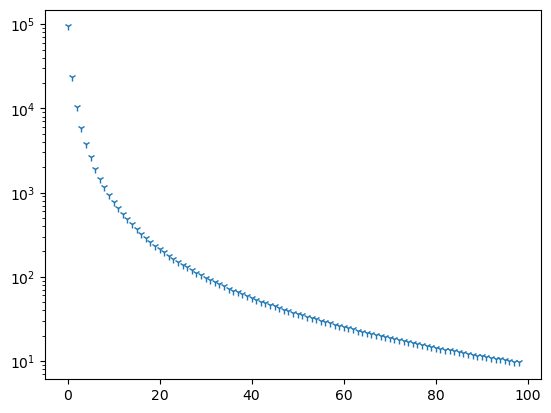

In [4]:
import matplotlib.pyplot as plt
error_trotter = []
for layers in range(1,100):
    eps_tr = trotter_error_bound(p_order=2, final_time=8, trotter_steps=layers, params=hamiltonian_params)
    error_trotter.append(eps_tr)

plt.plot(error_trotter, '1')
plt.yscale('log')

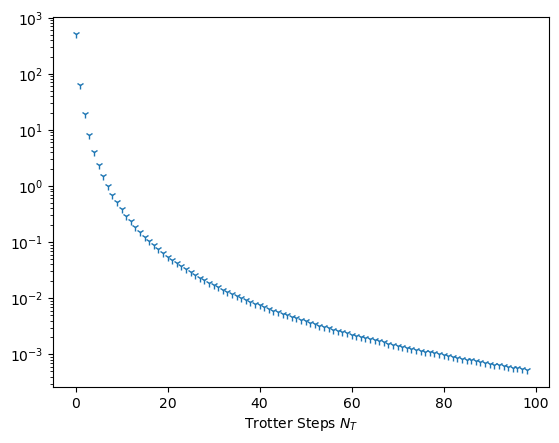

In [5]:
error_trotter = []
final_time = 8
p = 2
for layers in range(1,100):
    error_trotter.append((final_time/layers)**(p+1))

plt.plot(error_trotter, '1')
plt.xlabel("Trotter Steps $N_T$")
plt.yscale('log')

Let us call 
$$ A = - J \sum_n \tau_n^{z} - h \sum_n \sigma_{(n, n+1)}^{z} \quad \text{and} \quad B= - \lambda \sum_n \tau^{x}_{n+1} \sigma_{(n, n+1)}^{x} \tau^{x}_n $$

then we have 
$$||\mathcal{S}_2(t) - e^{-itH}|| \leq \frac{t^3}{12}||[B,[B,A]]|| + \frac{t^3}{24}||[A,[A,B]]||$$


In [6]:
def commutator(A,B):
    return A@B - B@A

def error_bound(A,B):
    comm_BA = commutator(B,A)
    comm_B_BA = commutator(B,comm_BA)
    u,s_sp,v = svds(comm_B_BA)
    print(max(s_sp))
    norm_1 = max(s_sp)

    comm_AB = commutator(A,B)
    comm_A_AB = commutator(A,comm_AB)
    u,s_sp,v = svds(comm_B_BA)
    print(max(s_sp))
    norm_2 = max(s_sp)

    bound = final_time**3/12*norm_1 + final_time**3/24*norm_2
    print(f"bound: {bound}")
    return bound

In [7]:
L = 3 # dual space sites
n = 2*L-1 # qubits, (n//2)+1 of matter and n//2 of gauge
J = 1
h = 0.05
lamb = 0.7
final_time = 8
A = sparse_hamiltonian(J=J, h=h, lamb=0, chain_length=L)
B = sparse_hamiltonian(J=0, h=0, lamb=lamb, chain_length=L)
bound = error_bound(A,B)

9.604000000000001
9.604000000000001
bound: 614.656


## Circuit Error

We use as a first estimate the Error Per Layered Gate (EPLG) which is specific of the chosen backend. 

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
# from cobos.tokens import ibm_token, group_instance
from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
device = "ibm_torino"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

ModuleNotFoundError: No module named 'fradm.tokens'

In [4]:
L = 12
J = 1
h = 0.05
lamb = 0.7

x_basis = False

particle_pair_left_position = L//2 - 1
particle_pair_length = 1

final_time = 8
layers = 25
measure_every_layers = 1

Longest circuit has 100 2-qb depth


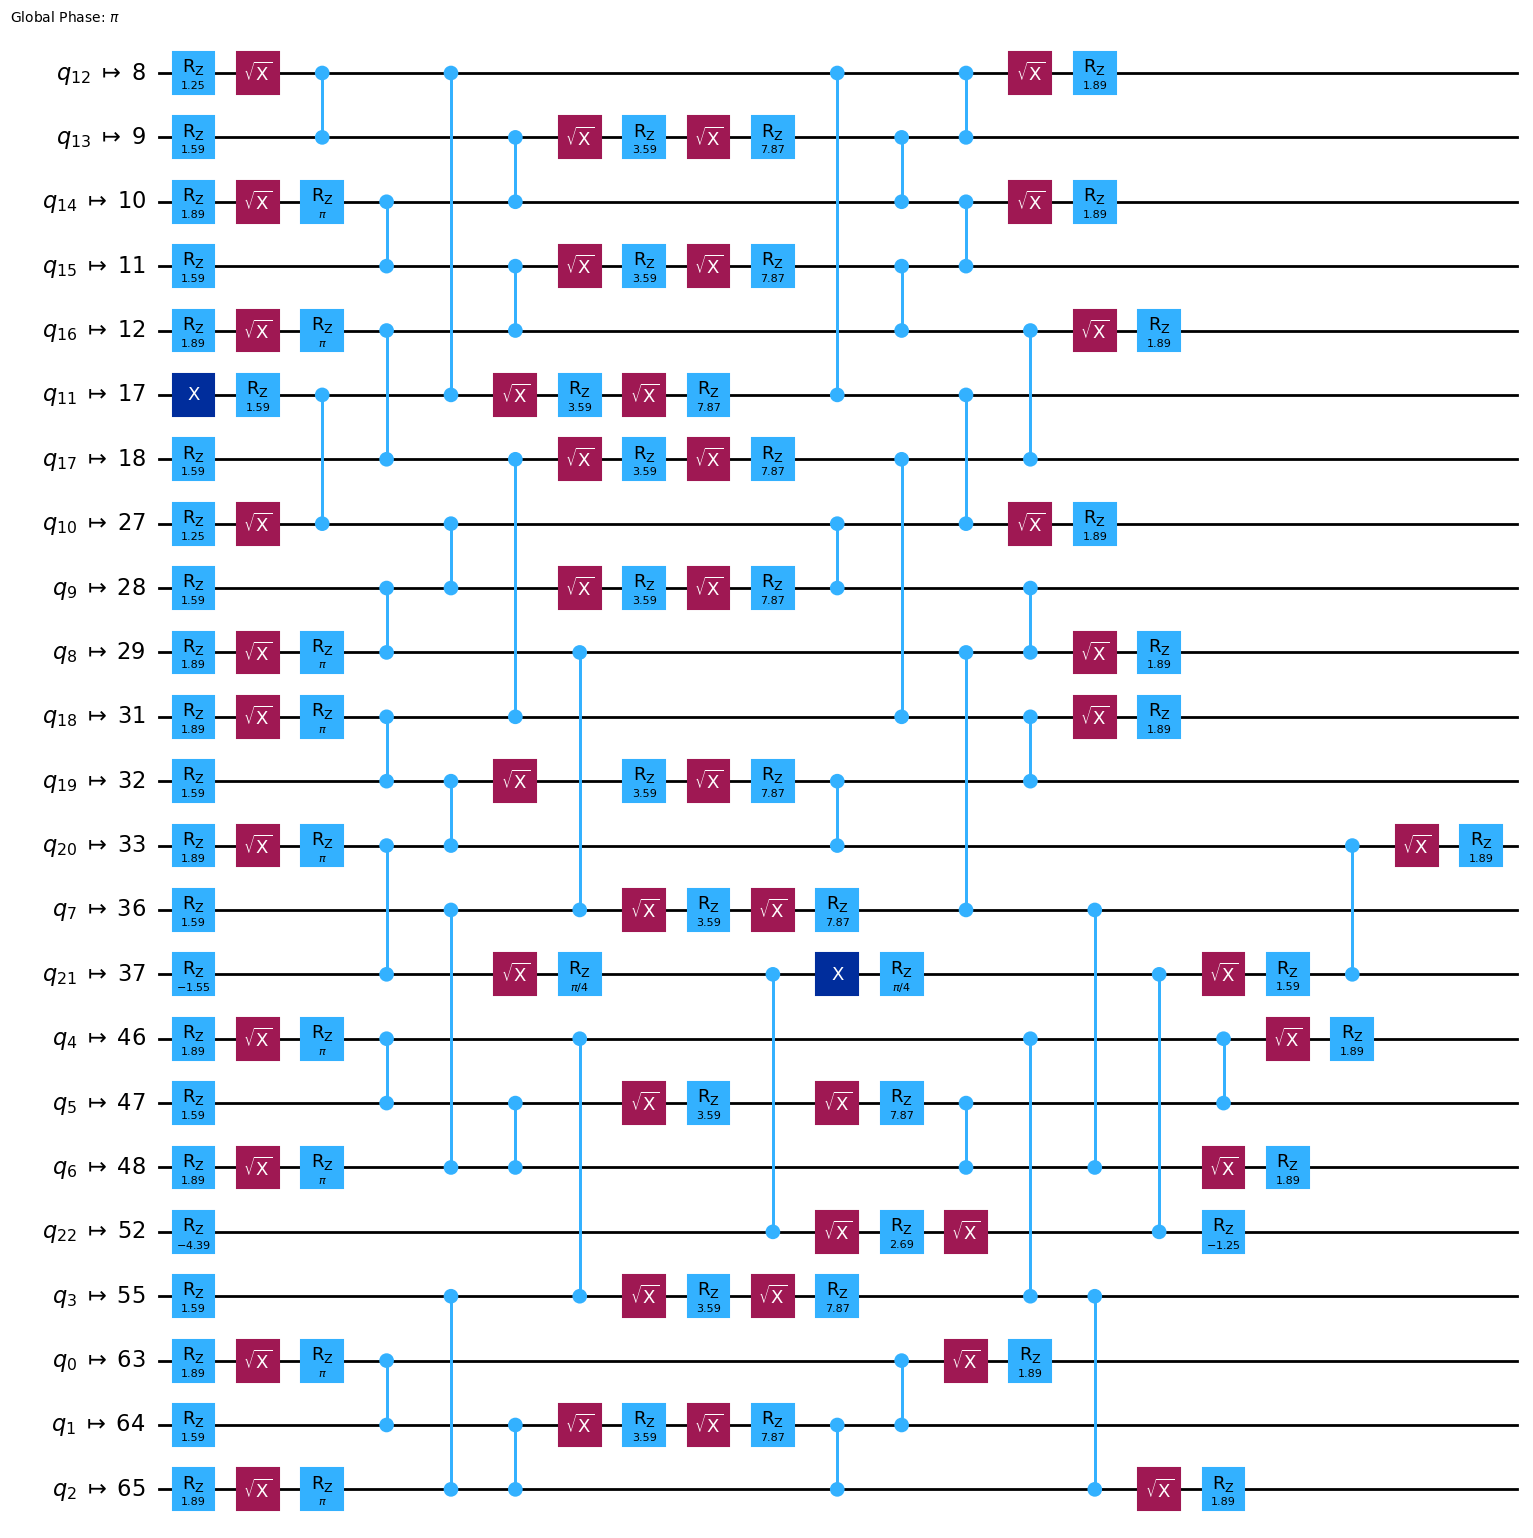

In [7]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22]
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22, 21, 20, 33, 39, 40,
#                41, 42, 43, 44, 45, 54, 64, 63, 62, 72, 
#                81, 82, 83, 92, 102, 103, 104, 111, 122,
#                121, 120, 119, 118, 116, 115, 114, 109, 96, 95]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers, x_basis=x_basis)
longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1, filename="transpiled_circuit.png")

In [57]:
dir(physical_circuits[0].layout)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_input_qubit_count',
 '_output_qubit_list',
 'final_index_layout',
 'final_layout',
 'final_virtual_layout',
 'initial_index_layout',
 'initial_layout',
 'initial_virtual_layout',
 'input_qubit_mapping',
 'routing_permutation']

In [1]:
import numpy as np

def circuit_error_bound(physical_circuit, backend):
    physical_layout = physical_circuit[0].layout.final_index_layout()

    readout_errs = []
    for qubit in physical_layout:
        err = backend.properties().readout_error(qubit=qubit)
        readout_errs.append(err)

    av_readout_err = np.mean(readout_errs)
    return av_readout_err

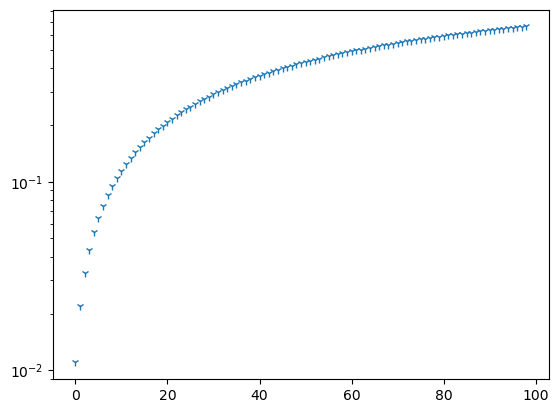

In [3]:
error_circ = []
import matplotlib.pyplot as plt
meas_err = 1 #circuit_error_bound(physical_circuit=physical_circuits, backend=backend)
readout_err = True
readout_err = False
for layers in range(1,100):
    if readout_err:
        eps_circ = (1 - (1-1.1*1e-2) ** layers) * meas_err
    else:
        eps_circ = 1 - (1-1.1*1e-2) ** layers
    error_circ.append(eps_circ)

plt.plot(error_circ, '1')
plt.yscale('log')

## Comparison

In [4]:
error_trotter = []
final_time = 8
p = 2
for layers in range(1,100):
    error_trotter.append((final_time/layers)**(p+1))

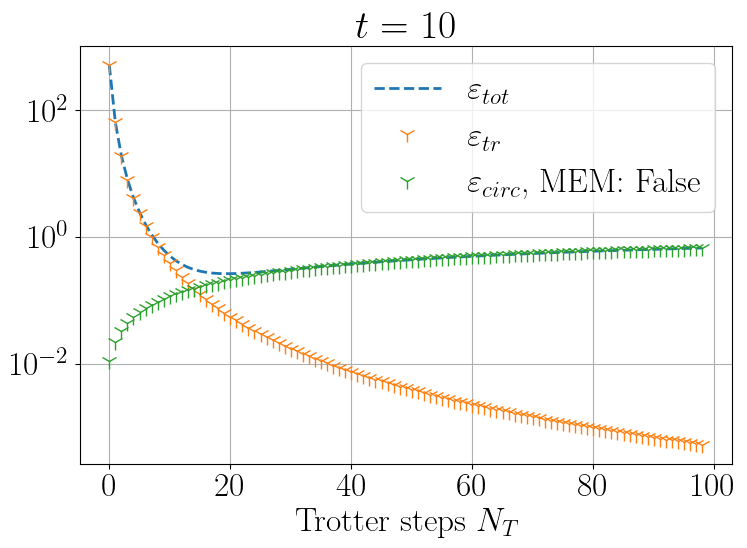

In [32]:
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")

fig = plt.figure(figsize=[8, 6])

plt.plot([tr+circ for tr,circ in zip(error_trotter,error_circ)],'--', label=r"$\varepsilon_{tot}$", linewidth=2)
plt.plot(error_trotter, '1', label=r"$\varepsilon_{tr}$", markersize=12)
plt.plot(error_circ, '1', label=r"$\varepsilon_{circ}$,  "+f"MEM: {readout_err}", markersize=12)
plt.yscale('log')
plt.title(f"$t = {final_time}$")
plt.xlabel("Trotter steps $N_T$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("optimal_trotter.pdf")

$$\delta^{(p+1)} , \delta=t/N_T$$

In [6]:
err_tot = [tr+circ for tr,circ in zip(error_trotter,error_circ)]
np.argmin(err_tot)

19

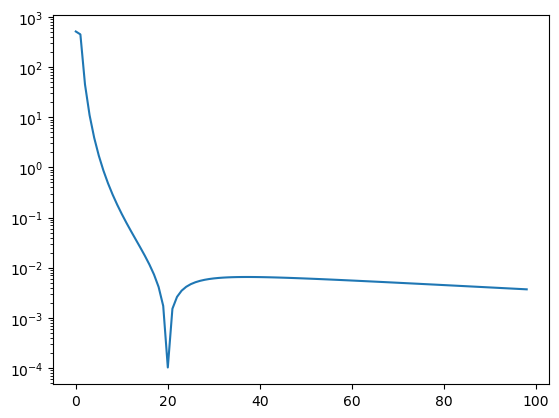

In [7]:
i = 0
diff = []
for err in err_tot:
    diff.append(np.abs(err-i))
    i = err

plt.plot(diff)
plt.yscale('log')

In [8]:
good_trotters = []
for i in range(10):
    mask = np.isclose(diff[np.argmin(diff)],diff[np.argmin(diff)+i], atol=min(diff)*1e+1)
    if mask:
        good_trotters.append(np.argmin(diff)+i)

for i in range(10):
    mask = np.isclose(diff[np.argmin(diff)],diff[np.argmin(diff)-i], atol=min(diff)*1e+1)
    if mask:
        good_trotters.append(np.argmin(diff)-i)
print(np.sort(good_trotters))


[20 20]


## Final function for optimal number of layers

In [9]:
import numpy as np

def get_erradj_number_of_trotter_layers(times, eplg_absolute, trotter_order, max_layers=100):
    times_matrix = np.repeat(times, max_layers).reshape(len(times), max_layers)
    layers_arr = np.arange(1, max_layers + 1)
    error_trotter = (times_matrix/layers_arr)**(trotter_order + 1)
    error_hardware = 1 - (1-eplg_absolute) ** (4*layers_arr)
    error_total = error_trotter + error_hardware
    return np.argmin(error_total, axis=1) + 1

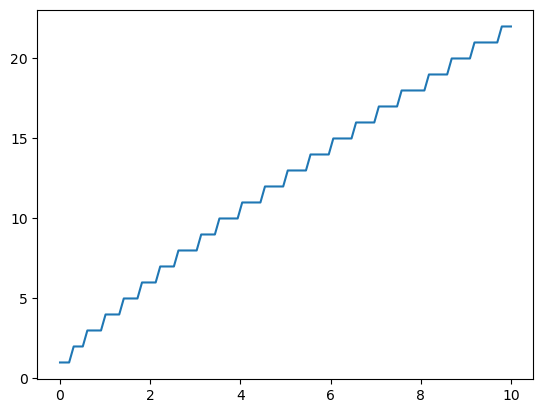

In [10]:
import matplotlib.pyplot as plt

final_time = 10
resolution = 100
times_arr = np.linspace(0, final_time, resolution)
layers_arr = get_erradj_number_of_trotter_layers(times_arr, 4.88e-3, 2)

plt.plot(times_arr, layers_arr)